# Get Data

In [ ]:
# cloning data gambar hasil resize dari github
!git clone https://github.com/Luthfi507/trash-classification.git

Cloning into 'trash-classification'...
remote: Enumerating objects: 5057, done.
remote: Counting objects: 100% (5057/5057), done.
remote: Compressing objects: 100% (5056/5056), done.
remote: Total 5057 (delta 0), reused 5057 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5057/5057), 28.38 MiB | 11.46 MiB/s, done.
Updating files: 100% (5054/5054), done.


# Import Library

In [ ]:
!pip install -q split-folders evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import models, transforms
from transformers import Trainer, TrainingArguments, PreTrainedModel, PretrainedConfig
import evaluate

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

from sklearn.metrics import confusion_matrix
import os
import wandb
import splitfolders
import random

# Data Preparation

In [ ]:
data_dir = 'trash-classification/data'

# memisahkan data menjadi train dan test dengan rasio 80:20
splitfolders.ratio(data_dir, output='dataset', seed=507, ratio=(.8, .2), group_prefix=None)

Copying files: 5054 files [00:01, 3916.95 files/s]


In [ ]:
labels = os.listdir(data_dir)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

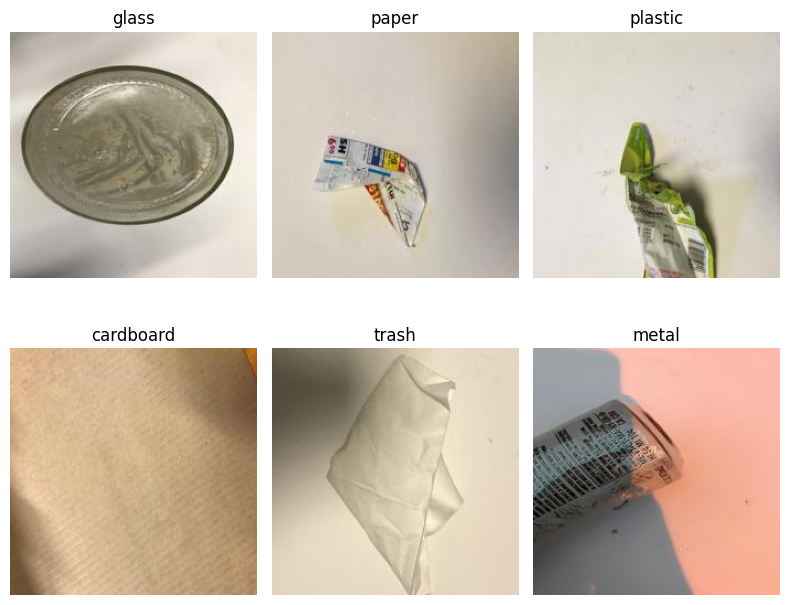

In [ ]:
# menampilkan sampel gambar dari setiap label
fig = plt.figure(figsize=(8, 8))

for i, label in enumerate(labels):
    num_img = len(os.listdir(f'dataset/train/{label}'))
    random_int = random.randint(0, num_img-1)

    img_name = os.listdir(f'dataset/train/{label}')[random_int]
    img_path = f'dataset/train/{label}/{img_name}'
    img = Image.open(img_path)

    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    plt.tight_layout()

plt.show()

Semua gambar memiliki ukuran yang serupa yaitu (224, 224).

In [ ]:
# melihat banyaknya gambar pada data train
for label in labels:
    num_img = len(os.listdir(f'dataset/train/{label}'))
    print(f'{label}: {num_img}')

glass: 801
paper: 950
plastic: 771
metal: 656
cardboard: 644
trash: 219


Distribusi gambar tidak seimbang. Data dengan label paling sedikit adalah label `trash` dan terbanyak adalah `paper`. Selanjutnya gambar akan diaugmentasi supaya mendapatkan lebih banyak variasi.

In [ ]:
# membuat custom dataset yang mewarisi class Dataset dari PyTorch
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform # fungsi untuk augmentasi gambar
        self.img_labels = []
        self.img_paths = []

        for label in os.listdir(img_dir): # melakukan looping untuk setiap label gambar
            class_dir = os.path.join(img_dir, label)

            # menambahkan path dan label
            if os.path.isdir(class_dir):
                class_images = [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]
                self.img_paths.extend(class_images)
                self.img_labels.extend([os.listdir(img_dir).index(label)] * len(class_images))

    # fungsi untuk mengembalikan jumlah gambar
    def __len__(self):
        return len(self.img_paths)

    # fungsi untuk mengambil gambar berdasarkan idx
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB') # konversi gambar ke format RGB
        label = self.img_labels[idx]

        if self.transform:
           image = self.transform(image) # transformasi gambar

        return {'pixel_values': image, 'labels': label}

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # membalik gambar secara horizontal
    transforms.RandomRotation(10), # memutar gambar secara random hingga 10 derajat
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # mengubah warna gambar
    transforms.ToTensor(), # mengonversi gambar ke format tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalisasi gambar berdasarkan dataset ImageNet
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
train_dir = 'dataset/train'
test_dir = 'dataset/val'

train_dataset = ImageDataset(train_dir, transform=train_transform)
test_dataset = ImageDataset(test_dir, transform=test_transform)

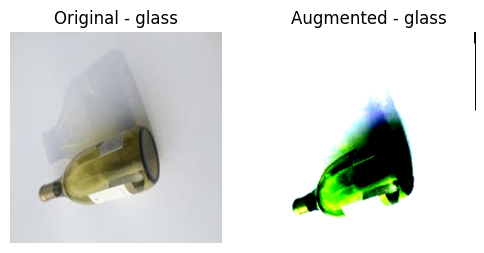

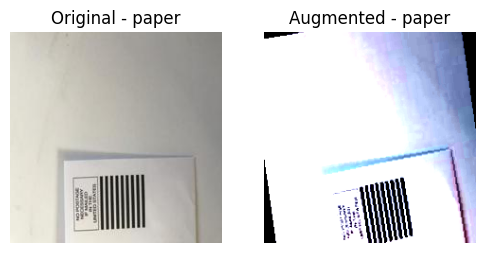

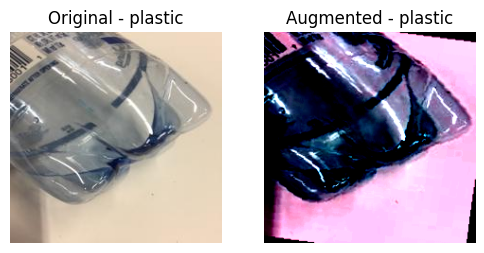

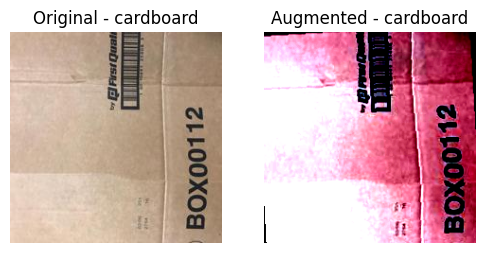

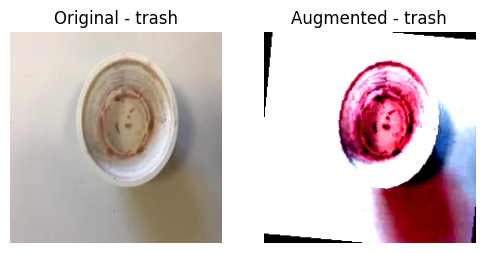

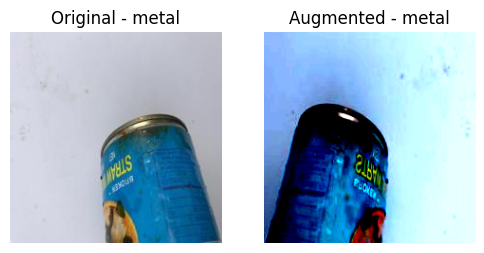

In [ ]:
# membandingkan data asli dengan data augmentasi
for label in labels:
    indices = [i for i, x in enumerate(train_dataset.img_labels) if id2label[x] == label]
    rand_int = random.randint(0, len(indices) - 1)
    idx = indices[rand_int]

    ori_name = os.listdir(f'dataset/train/{label}')[rand_int]
    ori_path = f'dataset/train/{label}/{ori_name}'
    ori = Image.open(ori_path).convert('RGB')

    aug_data = train_dataset[idx]
    aug = aug_data['pixel_values']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

    ax1.imshow(ori)
    ax1.set_title(f'Original - {label}')
    ax1.axis('off')

    ax2.imshow(aug.permute(1, 2, 0))
    ax2.set_title(f'Augmented - {label}')
    ax2.axis('off')

    plt.show()

Dari hasil augmentasi gambar terlihat bahwa arah gambar berubah dan warna gambar menjadi berbeda. Pendekatan ini dilakukan supaya model dapat mengenali berbagai variasi gambar dan membantu menangani jumlah gambar yang tidak sama untuk setiap kelas (class imbalanced)

# Model

In [ ]:
# fungsi untuk menghitung akurasi
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = evaluate.load('accuracy')
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
# membuat class konfigurasi yang mewarisi PretrainedConfig dari PyTorch
class CustomConfig(PretrainedConfig):
    model_type = 'ResNet18'

    def __init__(self, num_labels=6, **kwargs):
        super().__init__(**kwargs)
        self.num_labels = num_labels

In [ ]:
# class untuk menyimpan base_model dan mengatur layer akhir sesuai dengan jumlah kelas
class Models(nn.Module):
    def __init__(self, base_model, config):
        super(Models, self).__init__()
        self.base_model = base_model

        # memeriksa apakah base_model mempunyai atribut fc seperti pada model ResNet
        if hasattr(self.base_model, 'fc'):
            self.base_model.fc = nn.Linear(self.base_model.fc.in_features, config.num_labels)

        # memeriksa apakah model mempunyai atribut classifier seperti model DenseNet
        elif hasattr(self.base_model, 'classifier'):
            in_features = self.base_model.classifier[-1].in_features
            self.base_model.classifier[-1] = nn.Linear(in_features, config.num_labels)

    def forward(self, x):
        x = self.base_model(x)
        return x

In [ ]:
class ImageClassificationModel(PreTrainedModel):
    config_class = CustomConfig

    def __init__(self, config, base_model):
        super().__init__(config)
        self.model = Models(base_model, config)

    def forward(self, pixel_values, labels=None):
        outputs = self.model(pixel_values) # menghasilkan prediksi label

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss() # menginisiasi fungsi loss
            loss = loss_fct(outputs, labels) # menghitung nilai loss
            return {'loss': loss, 'logits': outputs}

        return outputs

In [ ]:
config = CustomConfig(num_labels=6)
config.id2label = id2label
config.label2id = label2id

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# membuat environment untuk wandb
%env WANDB_PROJECT=trash-classification
%env WANDB_LOG_MODEL=end

env: WANDB_PROJECT=trash-classification
env: WANDB_LOG_MODEL=end


In [ ]:
# menginisiasi model
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = ImageClassificationModel(config, base_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


In [ ]:
model

ImageClassificationModel(
  (model): Models(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

ResNet (Resudual Network) adalah model deep learning berbasis convolutional neural network (CNN). Salah satu inovasi utama dari arsitektur ini adalah blok residual yang memunginkan pembelajaran lebih efisien dalam jaringan yang sangat dalam. ResNet dilatih pada dataset ImageNet dan memiliki berbagai versi. Seperti namanya, ResNet18 memiliki 18 layers yang terdiri dari lapisan konvolusi dan lapisan fully connected.

![ResNet18](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*OkpgHpmqDuor9FKay8_9hQ.png)

In [ ]:
# menginisiasi argumen atau parameter untuk melatih data
training_args = TrainingArguments(
    output_dir='trash-classification',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='wandb',
    run_name='ResNet'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.342066,0.875617
2,No log,0.224489,0.928924
3,No log,0.206537,0.923988
4,0.319800,0.177665,0.937808
5,0.319800,0.123610,0.951629
6,0.319800,0.119073,0.955577
7,0.319800,0.130998,0.958539
8,0.055700,0.125380,0.957552
9,0.055700,0.112724,0.961500
10,0.055700,0.112889,0.960513


TrainOutput(global_step=1270, training_loss=0.15280041619548648, metrics={'train_runtime': 515.9692, 'train_samples_per_second': 78.319, 'train_steps_per_second': 2.461, 'total_flos': 0.0, 'train_loss': 0.15280041619548648, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.11272403597831726,
 'eval_accuracy': 0.9615004935834156,
 'eval_runtime': 2.8975,
 'eval_samples_per_second': 349.607,
 'eval_steps_per_second': 11.044,
 'epoch': 10.0}

Hasil pelatihan memperlihatkan nilai akurasi yang baik pada data latih maupun pada data uji. Dengan melatih model sebanyak 10 epoch, diperoleh nilai akurasi data latih sebesar **96.05%** dan akurasi data tes sebesar **96.15%**. Hal tersebut menunjukkan nilai yang bagus, sehingga bisa disimpulkan bahwa model sudah bisa melakukan generalisasi dan memprediksi gambar dengan baik.

In [ ]:
wandb.finish()

eval/accuracy,▂▁▂▂▆▅▆▇██████
eval/loss,▇██▇▄▄▃▁▁▂▁▁▁▁
eval/runtime,█▃▁▃▁▁▁▂▂▁▁▁▃▂
eval/samples_per_second,▁▅█▅█▇▇▇▆███▅▇
eval/steps_per_second,▁▅█▅█▇▇▇▆███▅▇
train/epoch,▁▁▁▁▂▃▃▃▄▅▆▆▆▇███
train/global_step,▁▁▁▁▂▃▃▃▄▅▆▆▆▇███
train/grad_norm,▁█
train/learning_rate,█▁
train/loss,█▁
eval/accuracy,0.9615


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# push hasil pelatihan ke huggingface
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/luthfi507/trash-classification/commit/40b0c1ed8428568c16d960fdfd4b1eda3ed9b1c3', commit_message='End of training', commit_description='', oid='40b0c1ed8428568c16d960fdfd4b1eda3ed9b1c3', pr_url=None, pr_revision=None, pr_num=None)

# Model Inference

In [ ]:
# mengambil model hasil pelatihan dari wandb
run = wandb.init()
artifact = run.use_artifact('luthfi-organization/trash-classification/model-ResNet:v2', type='model')
artifact_dir = artifact.download()

wandb:   4 of 4 files downloaded.  


In [ ]:
# melakukan konfigurasi sesuai dengan kelas config dan model yang telah dibuat
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
config = CustomConfig.from_json_file('artifacts/model-ResNet:v2/config.json')
model = ImageClassificationModel(config, base_model)

In [ ]:
from safetensors.torch import load_file

state_dict = load_file('artifacts/model-ResNet:v2/model.safetensors')
model.load_state_dict(state_dict)
model.eval() # buat model dalam mode evaluasi

ImageClassificationModel(
  (model): Models(
    (base_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

In [ ]:
# preprocess gambar
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# fungsi meyiapkan gambar untuk gambar diolah oleh model
def prepare_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0) # menambahkan dimensi batch ke tensor menjadi bentuk (1, C, H, W)

# fungsi prediksi gambar
def predict(image_path):
    image_tensor = prepare_image(image_path)

    with torch.no_grad():
        outputs = model(image_tensor)
        predictions = torch.argmax(outputs, dim=1)
    result =  predictions.item()
    return config.id2label[result]

In [ ]:
# mengambil gambar random dari direktori
def get_random_image(label):
    label_dir = f'dataset/val/{label}'

    img_files = os.listdir(label_dir)
    img_name = random.choice(img_files)
    img_path = os.path.join(label_dir, img_name)

    return img_path

In [ ]:
# fungsi untuk menampilkan gambar dan label prediksi
def plot_image(img_path):
    result = predict(img_path)

    image = Image.open(img_path)
    plt.imshow(image)
    plt.title(f'Predict: {result}')

    plt.show()

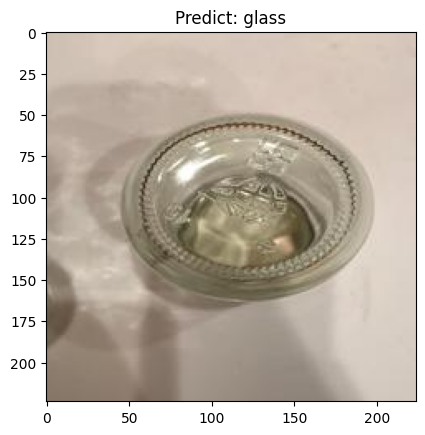

glass


In [ ]:
idx = random.randint(0, len(labels) - 1)
label = labels[idx]
img_path = get_random_image(label)

plot_image(img_path)
print(label)

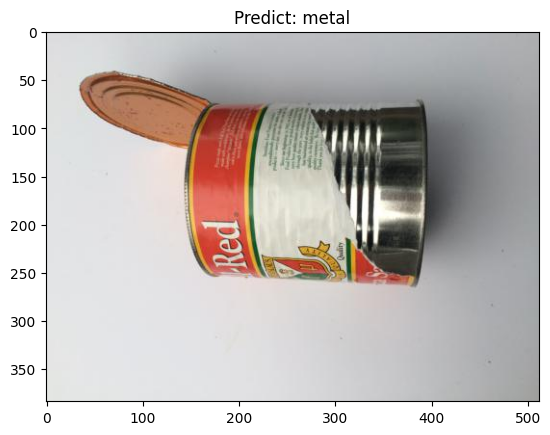

In [ ]:
img_path = 'metal122.jpg'

plot_image(img_path)